# Testing Basic OFDM functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from optic.modulation import modulateGray
from optic.metrics     import fastBERcalc, signal_power, theoryBER
from optic.models      import awgn, mzm, photodiode
from optic.modelsGPU   import ssfm
from optic.dsp         import lowPassFIR, firFilter, pnorm, pulseShape, decimate
from optic.core        import parameters
from optic.equalization import edc
from tqdm.notebook     import tqdm
from utils.ofdm        import modulateOFDM, demodulateOFDM, hermit
from commpy.utilities  import upsample
from tqdm.notebook     import tqdm
from optic.plot import plotPSD, pconst
from scipy.signal      import hilbert

pi = np.pi

In [2]:
#import scienceplots

#plt.style.use('science')
font = {'size':14}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 100

In [3]:
%load_ext autoreload
%autoreload 2

## Parameters

In [4]:
# Parâmetros do transmissor
paramTx = parameters()

# OFDM
M    = 16                       # Número de símbolos da constelação QAM
Nfft = 512                      # Tamanho da FFT
Ns = int(Nfft/2) - 1            # Número de sub-portadoras
N  = Ns                         # Número de portadoras de informação
Nz = Ns - N                     # Número de subportadoras nulas
G  = 4                          # Tamanho do prefixo cíclico
K  = 4                          # Número de portadoras piloto por bloco OFDM

Rb  = 6e9                       # Taxa de bits/s
Rs  = Rb*Ns*(1 +G/Nfft) / (np.log2(M)*N)      # Banda do sinal
SpS = 4                         # Amostras por símbolo
Fa  = Rs*SpS                    # Frequência de amostragem
Fc  = 193.4e12                  # Frequência da portadora óptica

## AWGN simulation

In [5]:
# Random bits sequency
bits = np.random.randint(2, size = ((Nfft-K-2)//2)*2**6)

# Maping bits - symbols
symbTx = modulateGray(bits, M, 'qam')
symbTx = pnorm(symbTx) # power normalization

# Pilot carriers
pilot = max(symbTx.real) + 1j*max(symbTx.imag)

# OFDM symbols generation
symbTx_OFDM, symbTx = modulateOFDM(Nfft, Ns, N, Nz, G, K, pilot, symbTx)

# Upsample + pulse shaping
pulse = pulseShape('rrc', SpS, alpha = 0.01)
pulse = pnorm(pulse)
sigOFDM_Tx = firFilter(pulse, upsample(symbTx_OFDM, SpS))

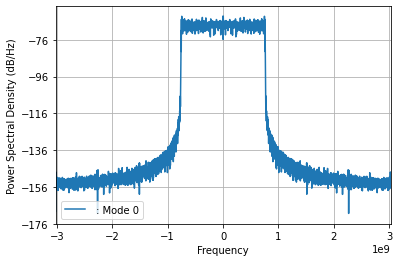

In [6]:
plotPSD(sigOFDM_Tx, Fa);

In [7]:
SNR = np.arange(5,25)
BER = np.zeros(SNR.shape)
BERth = np.zeros(SNR.shape)
SNRest = np.zeros(SNR.shape)

for kk, runSNR in enumerate(SNR):
    sigOFDM_Rx = awgn(sigOFDM_Tx, runSNR, Fa, Rs)
    sigOFDM_Rx = firFilter(pulse, sigOFDM_Rx)

    sigOFDM_Rx = sigOFDM_Rx[2::SpS] # downsampling to 1 sample per symbol

    # OFDM demodulation
    symbRx, symbRx_neq, H_abs, H_pha = demodulateOFDM(Nfft, Ns, N, Nz, G, K, pilot, pnorm(sigOFDM_Rx))
    
    discard = 100
    ind = np.arange(discard,len(symbRx)-discard)
    BER[kk], _, SNRest[kk] = fastBERcalc(symbRx[ind], symbTx[ind], M, 'qam')
    EbN0 = SNR[kk] - 10*np.log10(np.log2(M))
    BERth[kk] = theoryBER(M, EbN0, 'qam')

C:\Users\edson\AppData\Local\Temp\ipykernel_5764\846748909.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(SNR, np.log10(BER),'-o', ms= 6, label='BER '+str(M) +'QAM')


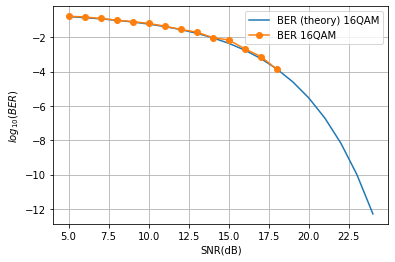

In [8]:
plt.plot(SNR, np.log10(BERth),'-', label='BER (theory) '+str(M) +'QAM')
plt.plot(SNR, np.log10(BER),'-o', ms= 6, label='BER '+str(M) +'QAM')
plt.grid()
plt.xlabel('SNR(dB)')
plt.ylabel('$log_{10}(BER)$');
plt.legend()

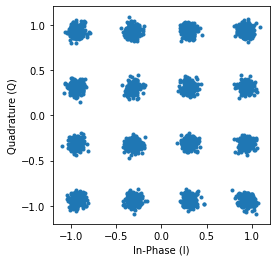

In [9]:
pconst(symbRx[ind], pType='fast');

## New modulate/demodulate OFDM functions

In [67]:
from scipy.fftpack     import fft, ifft
from scipy.interpolate import interp1d

def modulateOFDM_v2(Nfft, G, Np, pilot, pilotIndex, symbTx, hermitSym=False):
    """
    OFDM modulator.
    Parameters
    ----------
    Nfft   : scalar
             size of IFFT
    Ns     : scalar
             number of subcarriers
    N      : scalar
             number of information subcarriers   
    G      : scalar
             cyclic prefix length
    Np      : scalar
             number of pilot carriers per OFDM block
    pilot  : complex-valued scalar
             symbol chose for pilot carriers
    pilotIndex  : scalar
             position of the pilot carriers
    symbTx : complex-valued array
             symbols sequency transmitted
    
    Returns
    -------
    symbTx_OFDM : complex-valued np.array
                  OFDM symbols sequency transmitted
    """    
    numSymb = len(symbTx)  
        
    if hermitSym: # data generation with hermitian symmetry        
        subCarriers = np.arange(1, Nfft//2) # index of subcarriers available       
        numOFDMframes = 2*numSymb//(Nfft - Np - 2) # total number of OFDM frames to be generated     
    else:       
        subCarriers = np.arange(0, Nfft)        
        numOFDMframes = numSymb//(Nfft - Np)  
         
    dataIndex  = np.array(list(set(subCarriers) - set(pilotIndex))) # index of data carrying subcarriers
    symbPerFrame = len(dataIndex) # number of data symbols per OFDM frame
    
    sigTxPar = np.zeros((numOFDMframes, Nfft + G), dtype=complex)
    rot = np.arange(len(pilotIndex))*np.pi/2
    
    for indFrame in range(numOFDMframes):
        # allocate pilot symbols
        sigTxPar[indFrame, pilotIndex] = pilot*np.exp(1j*rot)
        
        # allocate data symbols
        sigTxPar[indFrame, dataIndex] = symbTx[indFrame*symbPerFrame:(indFrame+1)*symbPerFrame]
        
        if hermitSym:
            sigTxPar[indFrame,0:Nfft] = hermit(sigTxPar[indFrame,1:Nfft//2])
                      
        # Apply IFFT
        sigTxPar[indFrame, 0:Nfft] = ifft(sigTxPar[indFrame,0:Nfft])/np.sqrt(Nfft)
        
        # Add CP
        sigTxPar[indFrame, Nfft:] = sigTxPar[indFrame, 0:G] 
        
    # Convert parallel to serial:    
    symbTx_OFDM = sigTxPar.reshape(1,-1).reshape(-1,)
    
    return symbTx_OFDM


def demodulateOFDM_v2(Nfft, G, Np, pilot, pilotIndex, sigRx, hermitSym=False):
    """
    OFDM demodulator.
    Parameters
    ----------
    Nfft   : scalar
             size of IFFT     
    G      : scalar
             cyclic prefix length
    Np      : scalar
             number of pilot carriers per OFDM block
    pilot  : complex-valued scalar
             symbol chose for pilot carriers
    pilotIndex  : scalar
             position of the pilot carriers
    sigRx : complex-valued array
             symbols sequency transmitted
    
    Returns
    -------
    symbTx      : complex-valued np.array
                  symbols sequency transmitted
    symbTx_OFDM : complex-valued np.array
                  OFDM symbols sequency transmitted
    """    
    sigRx = sigRx.reshape(-1, Nfft + G) # serial to parallel
    numOFDMframes = sigRx.shape[0] # number of OFDM frames
       
    if hermitSym:       
        numSymb = numOFDMframes*(Nfft - Np - 2)//2  # number of data symbols      
        subCarriers = np.arange(1, Nfft//2) # number of subcarriers               
        pilotsRx = np.zeros((numOFDMframes, Np//2), dtype=complex)
    else:        
        numSymb = numOFDMframes*(Nfft - Np)
        subCarriers = np.arange(0, Nfft)        
        pilotsRx = np.zeros((numOFDMframes, Np), dtype=complex)
                
    dataIndex  = np.array(list(set(subCarriers) - set(pilotIndex))) # index of data carrying subcarriers
    symbPerFrame = len(dataIndex) # number of data symbols per OFDM frame
    
    symRx = np.zeros((numOFDMframes, symbPerFrame), dtype=complex)
       
    # Remove CP
    sigRx = sigRx[:, 0:Nfft]
        
    for indFrame in range(numOFDMframes):
        # Apply FFT
        sigRx_freq = fft(sigRx[indFrame,:])/np.sqrt(Nfft)
        
        if hermitSym:
            sigRx_freq = sigRx_freq[0:Nfft//2]
            
        # recover data and pilot symbols
        symRx[indFrame, :] = sigRx_freq[dataIndex]    
        pilotsRx[indFrame, :] = sigRx_freq[pilotIndex]                  
    
    rot = np.arange(len(pilotIndex))*np.pi/2
    
    # One tap equalization
    f_ang = interp1d(pilotIndex, np.angle(np.mean(pilotsRx/(pilot*np.exp(1j*rot)), axis=0)), fill_value="extrapolate")
    f_abs = interp1d(pilotIndex, np.abs(np.mean(pilotsRx/(pilot*np.exp(1j*rot)), axis=0)), fill_value="extrapolate")
    H_ang = f_ang(dataIndex)
    H_abs = f_abs(dataIndex)
          
    for indFrame in range(numOFDMframes):   
#         # One tap equalization
#         f_ang = interp1d(pilotIndex, np.angle(pilotsRx[indFrame, :]/(pilot*np.exp(1j*rot))), fill_value="extrapolate")
#         f_abs = interp1d(pilotIndex, np.abs(pilotsRx[indFrame, :]/(pilot*np.exp(1j*rot))), fill_value="extrapolate")
#         H_ang = f_ang(dataIndex)
#         H_abs = f_abs(dataIndex)
        symRx[indFrame, :] = symRx[indFrame, :]/(H_abs*np.exp(1j*H_ang))
        
    # Convert parallel to serial:  
    symbRx = pnorm(symRx.reshape(1,-1).reshape(-1,))
    
#     plt.figure()
#     plt.plot(dataIndex, H_abs,'.', label='abs')
#     plt.grid()
#     plt.legend()
    
#     plt.figure()
#     plt.plot(dataIndex, H_ang,'.', label='ang')
#     plt.grid()
#     plt.legend()
    
    return symbRx, pilotsRx

## Check performance with AWGN simulation

In [68]:
# OFDM
M    = 16                       # Número de símbolos da constelação QAM
Nfft = 512                      # Tamanho da FFT
G  = 4                          # Tamanho do prefixo cíclico
K  = 8                          # Número de portadoras piloto por bloco OFDM
SpS = 4
pilotIndex = [1, 64, 128, 254]

# Decimation parameters
paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = 1

In [69]:
# Random bits sequency
bits = np.random.randint(2, size = ((Nfft-K-2)//2)*2**8) # with hermitian symmetry
#bits = np.random.randint(2, size = ((Nfft-K)*2**6)) # without hermitian symmetry

# Maping bits - symbols
symbTx = modulateGray(bits, M, 'qam')
symbTx = pnorm(symbTx) # power normalization

# Pilot carriers
pilot = max(symbTx.real) + 1j*max(symbTx.imag)

# OFDM symbols generation
symbTx_OFDM = modulateOFDM_v2(Nfft, G, K, pilot, pilotIndex, symbTx, hermitSym=True)

# Upsample + pulse shaping
pulse = pulseShape('rrc', SpS, alpha = 0.01)
pulse = pnorm(pulse)
sigOFDM_Tx = firFilter(pulse, upsample(symbTx_OFDM, SpS))

In [70]:
SNR = np.arange(5,35)
BER = np.zeros(SNR.shape)
BERth = np.zeros(SNR.shape)
SNRest = np.zeros(SNR.shape)

for kk, runSNR in enumerate(SNR):
    sigOFDM_Rx = awgn(sigOFDM_Tx, runSNR, Fa, Rs)
    sigOFDM_Rx = firFilter(pulse, sigOFDM_Rx) # matched filtering   
    sigOFDM_Rx = decimate(sigOFDM_Rx.reshape(-1,1), paramDec) # downsampling to 1 sample per symbol
    #sigOFDM_Rx = sigOFDM_Rx[0::SpS]
    
    # OFDM demodulation
    symbRx, pilotsRx = demodulateOFDM_v2(Nfft, G, K, pilot, pilotIndex, sigOFDM_Rx, hermitSym=True)
    
    discard = 100
    ind = np.arange(discard,len(symbRx)-discard)
    BER[kk], _, SNRest[kk] = fastBERcalc(symbRx[ind], symbTx[ind], M, 'qam')
    EbN0 = SNR[kk] - 10*np.log10(np.log2(M))
    BERth[kk] = theoryBER(M, EbN0, 'qam')

C:\Users\edson\AppData\Local\Temp\ipykernel_5764\846748909.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(SNR, np.log10(BERth),'-', label='BER (theory) '+str(M) +'QAM')
C:\Users\edson\AppData\Local\Temp\ipykernel_5764\846748909.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(SNR, np.log10(BER),'-o', ms= 6, label='BER '+str(M) +'QAM')


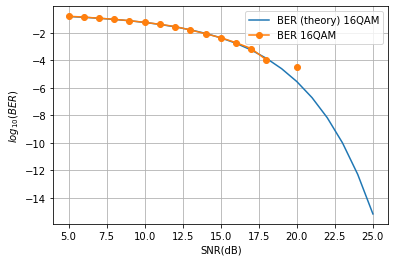

In [71]:
plt.plot(SNR, np.log10(BERth),'-', label='BER (theory) '+str(M) +'QAM')
plt.plot(SNR, np.log10(BER),'-o', ms= 6, label='BER '+str(M) +'QAM')
plt.grid()
plt.xlabel('SNR(dB)')
plt.ylabel('$log_{10}(BER)$');
plt.legend()

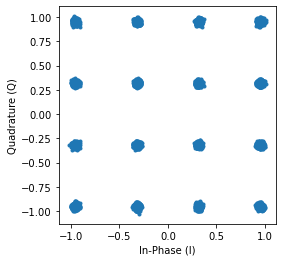

In [72]:
pconst(symbRx, pType='fast');

## New Tx/Rx functions

In [98]:
def Tx_v2(paramTx):
    """
    OFDM transmissor (Tx).
    Parameters
    ----------
    paramTx : parameter object (struct), optional
        Parameters of the OFDM transmissor.
        
    paramTx.SpS: samples per symbol [default: 32]
    paramTx.Rs: symbols rate [default: 1.5e9]
    paramTx.Fa: sampling frequency [default: 48e9]
    paramTx.Fc: optical carrier frequency [Hz] [default: 193.4e12 Hz]
    paramTx.Scheme: OFDM scheme ["CE-DDO-OFDM", "DDO-OFDM"] [default: "CE-DDO-OFDM"]
    
    paramTx.M: number of constellation symbols [default: 4]
    paramTx.Nfft: size of IFFT [default: 512]   
    paramTx.G: cyclic prefix length [default: 4]
    paramTx.K: number of pilot carriers per OFDM block [default: 8]
    
    paramTx.g:  gain in the signal before the MZM [default: 1.0]
    paramTx.Vπ: MZM switching voltage [V] [default: 4.4 V]
    paramTx.Vb: MZM bias voltage [V] [default: -2.2 V]
    paramTx.Pi_dBm: optical signal power [dBm] [default: 0 dBm]
    
    paramTx.H: phase modulation parameter [default: 0.35/(2*pi)]
    paramTx.fc: electrical carrier frequency [Hz] [default: 1e9 Hz]
    paramTx.A: electrical carrier amplitude [default: 1]
    
    Returns
    -------
    sigTxo : np.array
             optical signal.
    sigTx  : np.array
             time-domain baseband OFDM signal
    sigSig : np.array
             time-domain modulated signal (CE-DDO-OFDM or DDO-OFDM)
    symbTx : complex-valued np.array
             symbols sequency transmitted
    t      : np.array
             time vector
    pulse  : np.array
             pulse chose in transmission
    pilot  : complex-valued scalar
             symbol chose for pilot carriers
    """
    
    # Parâmetros da transmissão
    paramTx.SpS = getattr(paramTx, "SpS", 32)
    paramTx.Rs  = getattr(paramTx, "Rs", 1.5e9)
    paramTx.Fa  = getattr(paramTx, "Fa", 48e9)
    paramTx.Fc  = getattr(paramTx, "Fc", 193.4e12)
    paramTx.Scheme = getattr(paramTx, "Scheme", "CE-DDO-OFDM")
    
    # Parâmetros do esquema OFDM
    paramTx.M    = getattr(paramTx, "M", 4)
    paramTx.Nfft = getattr(paramTx, "Nfft", 512)
    paramTx.G    = getattr(paramTx, "G", 4)
    paramTx.K    = getattr(paramTx, "K", 8)
    paramTx.pilotIndex = getattr(paramTx, "pilotIndex", [1, 64, 128, 254])
    
    # Parâmetros da portadora óptica
    paramTx.g      = getattr(paramTx, "g", 1.0)
    paramTx.Vπ     = getattr(paramTx, "Vπ", 4.4)
    paramTx.Vb     = getattr(paramTx, "Vb", -2.2)
    paramTx.Pi_dBm = getattr(paramTx, "Pi_dBm", 0)
    
    # Parâmetros da portadora elétrica
    paramTx.H  = getattr(paramTx, "H", 0.35/(2*pi))
    paramTx.fc = getattr(paramTx, "fc", 1e9)
    paramTx.A  = getattr(paramTx, "A", 1)

    Scheme = paramTx.Scheme
    SpS = paramTx.SpS
    Rs  = paramTx.Rs
    Fc  = paramTx.Fc
    Fa  = paramTx.Fa       # Sampling frequency
    Ta  = 1/Fa             # Sampling period
    
    M    = paramTx.M
    Nfft = paramTx.Nfft
    G    = paramTx.G
    K    = paramTx.K
    pilotIndex = paramTx.pilotIndex 
    
    H  = paramTx.H
    fc = paramTx.fc
    A  = paramTx.A
    
    g      = paramTx.g
    Vπ     = paramTx.Vπ
    Vb     = paramTx.Vb
    Pi_dBm = paramTx.Pi_dBm
    Pi     = 10**(Pi_dBm/10)*1e-3
    
    # Symbols constellation definiton
    constType = 'qam'
    
    # Random bits sequency
    bits = np.random.randint(2, size = ((Nfft-K-2)//2)*2**7)
    
    # Maping bits - symbols
    symbTx = modulateGray(bits, M, constType)
    symbTx = pnorm(symbTx)
    
    # Pilot carriers
    pilot = max(symbTx.real) + 1j*max(symbTx.imag)
    
    # OFDM symbols generation    
    symbTx_OFDM = modulateOFDM_v2(Nfft, G, K, pilot, pilotIndex, symbTx, hermitSym=True)
    symbTx_OFDM = pnorm(symbTx_OFDM)
    
    # Pulse choice
    pulse = pulseShape('rrc', SpS, alpha = 0.01)
    pulse = pnorm(pulse)
    
    # CE-DD-OFDM
    if(Scheme == "CE-DDO-OFDM"):
        # Pulse formatation
        sigTx = firFilter(pulse, upsample(symbTx_OFDM.real, SpS))
        t = np.arange(0, sigTx.size)*Ta
        
        # Optical modulation
        sigTx_CE = A*np.cos(2*pi*fc*t + 2*pi*H*pnorm(sigTx.real))
        Ai = np.sqrt(Pi) * np.ones(len(sigTx))
        sigTxo = mzm(Ai, sigTx_CE, Vπ, Vb)
        sigSig = sigTx_CE
    
    # DDO-OFDM
    else:
        # Pulse formatation
        sigTx = firFilter(pulse, upsample(symbTx_OFDM.real, SpS))
        sigTx = pnorm(sigTx)
        t = np.arange(0, sigTx.size)*Ta
        
        # Optical modulation
        sigTx_DD = g*sigTx.real*np.cos(2*pi*fc*t)
        Ai = np.sqrt(Pi) * np.ones(len(sigTx_DD))
        sigTxo = mzm(Ai, sigTx_DD, Vπ, Vb)
        sigSig = sigTx_DD
    
    return sigTxo, sigTx, sigSig, symbTx, t, pulse, pilot

In [99]:
def Rx_v2(ipd, pilot, pulse, t, paramRx):
    """
    OFDM receiver (Rx).
    Parameters
    ----------
    paramRx : parameter object (struct), optional
        Parameters of the OFDM receiver.
        
    paramRx.SpS: samples per symbol [default: 32]
    paramRx.Fa: sampling frequency [default: 48e9]
    paramRx.H: phase modulation parameter [default: 0.35/(2*pi)]
    paramRx.fc: electrical carrier frequency [Hz] [default: 1e9 Hz]
    paramRx.Scheme: OFDM scheme ["CE-DDO-OFDM", "DDO-OFDM"] [default: "CE-DDO-OFDM"]

    paramTx.Nfft: size of IFFT [default: 512]
    paramRx.G: cyclic prefix length [default: 4]
    paramRx.K: number of pilot carriers per OFDM block [default: 8]
    
    Returns
    -------
    symbRx     : complex-valued np.array
                 symbols sequency received
    symbRx_neq : complex-valued np.array
                 symbols sequency received with no equalization
    sigRx      : np.array
                 received signal after processing
    H_abs      : np.array
                 channel amplitude estimated 
    H_pha      : np.array
                 channel phase estimated
    """
    paramRx.SpS = getattr(paramRx, "SpS", 32)
    paramRx.Fa  = getattr(paramRx, "Fa", 48e9)
    paramRx.H   = getattr(paramRx, "H", 0.35/(2*pi))
    paramRx.fc  = getattr(paramRx, "fc", 1e9)
    paramRx.Scheme = getattr(paramRx, "Scheme", "CE-DDO-OFDM")  
    
    paramRx.Nfft = getattr(paramRx, "Nfft", 512) 
    paramRx.G = getattr(paramRx, "G", 4)
    paramRx.K = getattr(paramRx, "K", 8)
    paramRx.pilotIndex = getattr(paramRx, "pilotIndex", [1, 64, 128, 254])
    
    # Receiver parameters
    SpS = paramRx.SpS
    Scheme = paramRx.Scheme
    Fa  = paramRx.Fa
    H   = paramRx.H
    fc  = paramRx.fc
    
    Nfft = paramRx.Nfft
    G = paramRx.G
    K = paramRx.K
    pilotIndex = paramRx.pilotIndex 
    
    # Decimation parameters
    paramDec = parameters()
    paramDec.SpS_in = SpS
    paramDec.SpS_out = 1

    # DC level extraction
    I_Rx = ipd - ipd.mean()
    I_Rx = pnorm(I_Rx)
    
    # CE-DDO-OFDM
    if(Scheme == "CE-DDO-OFDM"):
        # Demodulação da fase
        signal_a = hilbert(I_Rx) * np.exp(-1j*2*pi*fc*t)
        sigRx = np.unwrap((np.arctan2(signal_a.imag, signal_a.real)), axis = 0)/(2*pi*H)
        sigRx = sigRx - sigRx.mean()
        
        # Seleção das amostras do sinal recebido 
        sigRx = firFilter(pulse, sigRx)
        symbRx_OFDM = decimate(sigRx.reshape(-1,1), paramDec) # downsampling to 1 sample per symbol
        symbRx_OFDM = pnorm(symbRx_OFDM)
        
    # DD-OFDM
    else:
        sigRx = firFilter(pulse, I_Rx*np.cos(2*pi*fc*t))
        symbRx_OFDM = decimate(sigRx.reshape(-1,1), paramDec) # downsampling to 1 sample per symbol
        symbRx_OFDM = pnorm(symbRx_OFDM)
    
    # OFDM demodulation
    symbRx, pilotsRx = demodulateOFDM_v2(Nfft, G, K, pilot, pilotIndex, symbRx_OFDM, hermitSym=True)
    
    return symbRx, pilotsRx

## Test DD-OFDM and CE-DD-OFDM 

In [148]:
# Parâmetros do transmissor
paramTx = parameters()

# OFDM
paramTx.M    = 16                       # Número de símbolos da constelação QAM
paramTx.Nfft = 512                      # Tamanho da FFT
paramTx.G  = 4                          # Tamanho do prefixo cíclico
paramTx.K  = 8                          # Número de portadoras piloto por bloco OFDM
paramTx.pilotIndex = [1, 64, 128, 254]  # localização das portadoras piloto
paramTx.Ns = paramTx.Nfft//2 - 1
Rb          = 3e9                       # Taxa de bits/s
paramTx.Rs  = (Rb/np.log2(paramTx.M))*(1 + paramTx.G/paramTx.Nfft)*(paramTx.Nfft/(paramTx.Nfft/2 - K/2 -1))   # Banda do sinal
paramTx.SpS = 8                         # Amostras por símbolo
paramTx.Fa  = paramTx.Rs*paramTx.SpS    # Frequência de amostragem
paramTx.Fc  = 193.4e12                  # Frequência da portadora óptica

# Portadora elétrica
paramTx.fc = 1e9                         # Frequência da portadora [Hz]
paramTx.H  = 0.35/(2*pi)

# MZM e potência de entrada
paramTx.Vπ = 4
paramTx.Pi_dBm = 2
paramTx.A = 2
paramTx.Vb = 0.5*paramTx.Vπ
paramTx.g = -0.55
paramTx.H = 0.35/(2*pi)

# Parâmetros do fotodetector
paramPD = parameters()

paramPD.R  = 1           # Responsividade
paramPD.Tc = 25          # Temperatura [°C]
paramPD.Id = 5e-9        # Corrente de escuro [A]
paramPD.RL = 50          # Resistência [Ω]
paramPD.B  = 1.9e9        # Largura de banda [Hz]
paramPD.Fs = paramTx.Fa  # Frequência de amostragem
paramPD.N  = 8001        # Tamanho do resposta do filtro
paramPD.ideal = True   # Definição do modelo: ideal ou real


# Parâmetros do receptor
paramRx = parameters()

paramRx.SpS = paramTx.SpS       # Amostras por símbolo
paramRx.Fa  = paramTx.Fa        # Frequência de amostragem
paramRx.H   = paramTx.H         # Índice de modulação
paramRx.fc  = paramTx.fc        # Frequência da portadora elétrica
paramRx.Nfft = paramTx.Nfft
paramRx.G  = paramTx.G
paramRx.K  = paramTx.K
paramRx.pilotIndex = paramTx.pilotIndex

# optical filter
filtro_optico_Tx = lowPassFIR(4e9, paramTx.Fa, 8001, typeF='rect')
filtro_optico_CEDD = lowPassFIR(2.9e9, paramTx.Fa, 8001, typeF='rect')
filtro_optico_DD = lowPassFIR(1.9e9, paramTx.Fa, 8001, typeF='rect')

In [149]:
OSNR = np.arange(5, 35, 1)

BER_CEDD_B2B = np.zeros(OSNR.shape)
BER_DD_B2B = np.zeros(OSNR.shape)

SNR_CEDD_B2B = np.zeros(OSNR.shape)
SNR_DD_B2B = np.zeros(OSNR.shape)

In [150]:
paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = paramTx.Scheme
for ind, osnr in enumerate(OSNR):     
        sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx_v2(paramTx)        
        sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
        snr = osnr - 10*np.log10(paramPD.B/(2*12.5e9))        
        sigRxo = awgn(sigTxo, snr, paramTx.Fa, paramPD.B)
        
        # optical filter
        sigRxo = firFilter(filtro_optico_CEDD, sigRxo)
        
        ipd = photodiode(sigRxo, paramPD)
        symbRx, _ = Rx_v2(ipd, pilot, pulse, t, paramRx)

        BER_CEDD_B2B[ind], _, SNR_CEDD_B2B[ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')       
        
        if ind == len(OSNR)-1:
            sigTxoCEDD = sigTxo.copy()

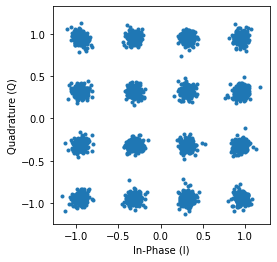

In [151]:
discard = 200
ind = np.arange(discard,len(symbRx)-discard)
pconst(symbRx[ind],pType='fast');

In [152]:
paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = paramTx.Scheme
for ind, osnr in enumerate(OSNR):     
        sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx_v2(paramTx)        
        sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
        snr = osnr - 10*np.log10(paramPD.B/(2*12.5e9))
        sigRxo = awgn(sigTxo, snr, paramTx.Fa, paramPD.B)
        
        # optical filter
        sigRxo = firFilter(filtro_optico_DD, sigRxo)
        
        ipd = photodiode(sigRxo, paramPD)
        symbRx, _ = Rx_v2(ipd, pilot, pulse, t, paramRx)

        BER_DD_B2B[ind], _, SNR_DD_B2B[ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam') 
        if ind == len(OSNR)-1:
            sigTxoDD = sigTxo.copy()

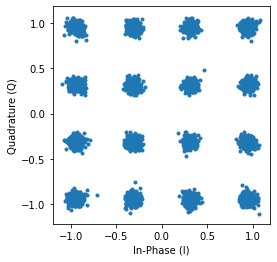

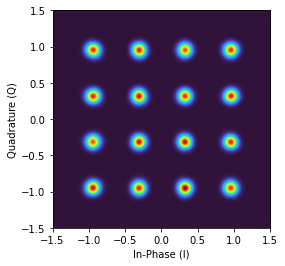

In [153]:
discard = 200
ind = np.arange(discard,len(symbRx)-discard)
pconst(symbRx[ind],pType='fast');
pconst(symbRx[ind]);

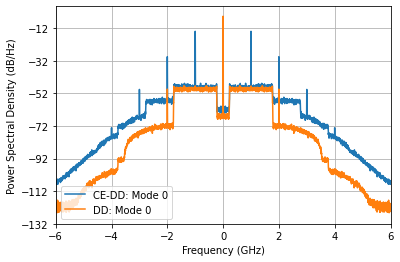

In [155]:
fig, _ = plotPSD(sigTxoCEDD, Fs=paramTx.Fa/1e9, label ='CE-DD');
fig, ax = plotPSD(sigTxoDD, Fs=paramTx.Fa/1e9, label ='DD', fig=plt.gcf());
ax.set_xlabel('Frequency (GHz)')
ax.set_xlim(-6,6);

C:\Users\edson\AppData\Local\Temp\ipykernel_5764\2305179782.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(OSNR, np.log10(BER_CEDD_B2B), '-o', ms = 6, lw = 2, label = f'CE-DD-OFDM')
C:\Users\edson\AppData\Local\Temp\ipykernel_5764\2305179782.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(OSNR, np.log10(BER_DD_B2B), '-o', ms = 6, lw = 2, label = f'DD-OFDM')


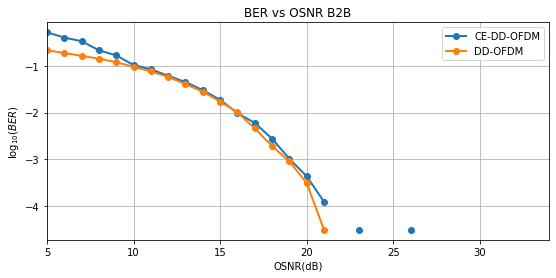

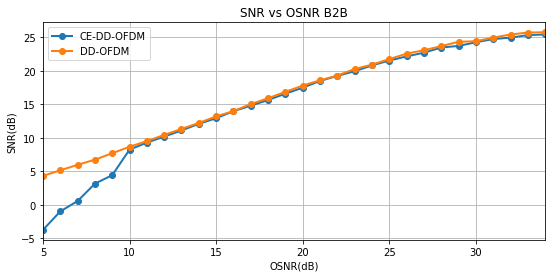

In [156]:
plt.figure(figsize = (9, 4))

plt.plot(OSNR, np.log10(BER_CEDD_B2B), '-o', ms = 6, lw = 2, label = f'CE-DD-OFDM')
plt.plot(OSNR, np.log10(BER_DD_B2B), '-o', ms = 6, lw = 2, label = f'DD-OFDM')
plt.title("BER vs OSNR B2B")
plt.xlabel(r"OSNR(dB)")
plt.ylabel(r"$\log_{10}(BER)$")
plt.legend(frameon = True)
plt.grid()
plt.xlim(min(OSNR), max(OSNR));


plt.figure(figsize = (9, 4))

plt.plot(OSNR, SNR_CEDD_B2B, '-o', ms = 6, lw = 2, label = f'CE-DD-OFDM')
plt.plot(OSNR, SNR_DD_B2B, '-o', ms = 6, lw = 2, label = f'DD-OFDM')

plt.title("SNR vs OSNR B2B")
plt.xlabel(r"OSNR(dB)")
plt.ylabel(r"SNR(dB)")
plt.legend(frameon = True)
plt.grid()
plt.xlim(min(OSNR), max(OSNR));

## BER vs Fiber input power

In [83]:
# Parâmetros da fibra
paramCh = parameters()
#paramCh.Ltotal  = 100
paramCh.Lspan   = 100         # Comprimento de um span de fibra [km]
paramCh.hz      = 0.05        # Comprimento do passo para o método SSF [km]
paramCh.alpha   = 0.2         # Atenuação da fibra [dB/km]
paramCh.D       = 16          # Parâmetro de dispersão cromática [ps/nm/km]
paramCh.gamma   = 1.3         # Parâmetro de não-linearidade da fibra [1/W/km]
paramCh.amp     = 'edfa'      # Tipo de amplificador
paramCh.NF      = 4.5         # Figura de ruído do amplificador [dB]
paramCh.Fc      = paramTx.Fc  # Frequência da portadora óptica [Hz]
paramCh.prgsBar = False

In [85]:
Pi_dBm  = np.arange(-8, 12.5) #np.array([-8, -4, -2, 0, 2, 4])
Ltotal  = np.arange(1200, 1300, 100)
osnrTx = 35

# CE-DDO-OFDM
paramTx.Pi_dBm = 10
paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = "CE-DDO-OFDM"

BER_CEDD  = np.zeros((len(Pi_dBm), len(Ltotal)))

for i, Pin in enumerate(tqdm(Pi_dBm)):    
    sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx_v2(paramTx)
    sigTxo = np.sqrt(10**(Pin/10)*1e-3) * pnorm(sigTxo)
       
    snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
    sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
    
    # optical filter
    sigTxo = firFilter(filtro_optico_Tx, sigTxo)
    sigRxo = sigTxo.copy()
    
    for j, Ltot in enumerate(Ltotal):
        paramCh.Ltotal = Ltot
        sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
        
        # optical filter
        sigRxo_ = firFilter(filtro_optico_CEDD, sigRxo)
        
        ipd = photodiode(sigRxo_, paramPD)
        symbRx, _ = Rx_v2(ipd, pilot, pnorm(pulse), t, paramRx)
        
        BER_CEDD[i, j] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]

  0%|          | 0/21 [00:00<?, ?it/s]

In [86]:
# DDO-OFDM
paramTx.Pi_dBm = 10
paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = "DDO-OFDM"

BER_DD  = np.zeros((len(Pi_dBm), len(Ltotal)))

for i, Pin in enumerate(tqdm(Pi_dBm)):
    sigTxo, sigTx, sigTx_DD, symbTx, t, pulse, pilot = Tx_v2(paramTx)
    sigTxo = np.sqrt(10**(Pin/10)*1e-3) * pnorm(sigTxo)
    sigRxo = sigTxo
    
    snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
    sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
    
    # optical filter
    sigTxo = firFilter(filtro_optico_Tx, sigTxo)
        
    for j, Ltot in enumerate(Ltotal):
        paramCh.Ltotal = Ltot
        sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
        
        # optical filter
        sigRxo_ = firFilter(filtro_optico_DD, sigRxo)
        
        ipd = photodiode(sigRxo_, paramPD)
        symbRx, _ = Rx_v2(ipd, pilot, pnorm(pulse), t, paramRx)
        
        BER_DD[i, j] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]

  0%|          | 0/21 [00:00<?, ?it/s]

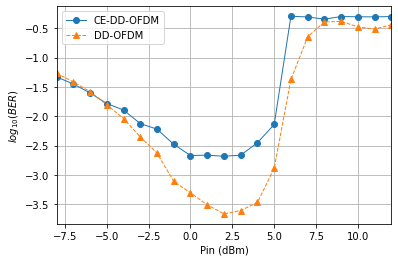

In [87]:
color = ['blue', 'orange', 'green', 'purple']
plt.plot(Pi_dBm, np.log10(BER_CEDD[:,0]), '-o', ms = 6, lw = 1, label = f"CE-DD-OFDM")
plt.plot(Pi_dBm, np.log10(BER_DD[:,0]), '--^', ms = 6, lw = 1, label = f"DD-OFDM")
plt.legend()
plt.grid()
plt.xlabel('Pin (dBm)')
plt.ylabel('$log_{10}(BER)$')
plt.xlim(min(Pi_dBm), max(Pi_dBm));